<h1><center>How Independent is the Independent Senators Group?</center></h1>
<h2><center>A Web-scraping, Random Forest Regression, and Data Visualization Project by Eric Jamieson</center></h2>
<h3><center>*Project is accurate as of February 14th 2021*</center></h3>

The Senate of Canada currently consists of [four caucuses](https://sencanada.ca/en/senators/) (as well as 6 non-affiliated Senators), the largest caucus being the Independent Senators Group (ISG) - accounting for 44 of the 94 currently occupied Senatorial seats, almost one half of the Senate.

The ISG's own charter states that members of the ISG ["should refrain from conduct which would undermine the public’s confidence in their independence"](https://www.isgsenate.ca/isg-charter) and additionally that one of the main purposes of the ISG is to "strengthen the work of the Senate as an effective, respected, and [non-partisan](https://www.isgsenate.ca/isg-charter) Chamber of sober second thought that is complementary to the House of Commons".


#### There has, however, been criticism and skepticism as to how independent and non-partisan the Independent Senators Group really is:

- In 2019, the [CBC reported](https://www.cbc.ca/news/politics/stefanovich-senate-reforms-trudeau-1.5187149) that some Conservative Party Senators did not believe that the Independent Senators Group was actually independent:

> Batters and her Conservative colleague Sen. Don Plett of Manitoba accuse Trudeau of appointing Liberals masked as Independents. "When it walks like a duck and talks like a duck, it's likely a duck," Plett said. "I don't think the Senate is broken. I think we need to just accept that we are all political people, and we need to continue with that."

- Earlier this year, Progressive Senate Group Senator Peter Harder went as far to say that the ISG was ruling with "[fear and favour](https://www.cbc.ca/news/politics/peter-harder-progressives-1.5569325)" after the Facilitator of the ISG, Senator Yuen Pau Woo, introduced a motion to strip committee seats from members who leave a recognized caucus or group (albeit with some exceptions). Senator Harder also expressed concern that "majoritarianism can become [a new partisanship](https://www.cbc.ca/news/politics/peter-harder-progressives-1.5569325) and I would caution against that behaviour because it doesn't respect the equality of senators and the importance of listening to voices outside any one group or caucus,". 


- Even one ISG member, Senator Murray Sinclair, expressed concern that "[the Senate still largely mirrors the state of political affairs in the House of Commons. As a result, it still follows a very partisan pattern,](https://www.cbc.ca/news/politics/stefanovich-senate-reforms-trudeau-1.5187149)".


### My goal is to determine if the Independent Senators Group is operating as a partisan political group with a preference for one of the major political parties. I will examine and model voting patterns in the Senate (and the House of Commons) in an attempt to ascertain whether or not the ISG is partisan or non-partisan.

#### More specifically, I would like to know:

1.  For Bills that originate in the Senate and are introduced by a member of the ISG, if the Bill reaches the House of Commons is any one party more likely to vote in favour (Yea) of the Bill compared to other parties – if so, how much more likely and which party? 




2. For Bills that originate in the House of Commons, if they are introduced by a member of a specific political party, e.g. the Liberals, are ISG members more likely to vote against this Bill? *I.e. does the political affiliation of the Member of Parliament who introduced the Bill hold predictive power in determining whether or not ISG members will vote against (or in favour of) the Bill?*
 


#### I make use of several abbreviations throughout this project. These abbreviations are listed here:

- ISG : Independent Senators Group



- CSG : Canadian Senate Group



- PSG : Progressive Senators Group



- C or CPC: Conservative Party (applicable to both House of Commons and Senate)


- Lib. : Liberal Party (applicable to both House of Commons and Senate)


- HOC : House of Commons



- MP : Member of Parliament


- PM : Prime Minister

In [1]:
# Importing a bunch of stuff we will need:

import pandas as pd
import numpy as np
from sklearn import (
    linear_model, metrics, neural_network, pipeline, preprocessing,
    model_selection, tree
)
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import qeds
import matplotlib as mpl
import requests
from bs4 import BeautifulSoup
from datetime import datetime 
import matplotlib.patches as ptches
import warnings; warnings.simplefilter('ignore')
import matplotlib.ticker as mtick 
from bs4.dammit import EncodingDetector


<h2><center>Introduction:</center></h2>

#### Before really delving into the research questions, let's take a quick look at the composition of the Senate in a few different ways:

- **A bar plot showing the number of Senators per Caucus**



- **A nested pie chart showing which Prime Minister appointed the Senators who are now in each Caucus**



- **And finally, a coloured dataframe showing changes in affiliations of (current) ISG Senators over the years**


In [11]:
# Getting the table of all current senators and sorting by date of nomination:
url = 'https://sencanada.ca/en/senators-list/'
senators_today = pd.read_html(url)
senators_today = senators_today[0]
senators_today["Date of nomination"][54] = "2011-05-25" # these two dates had footnotes attached to them so I have to re-name
senators_today["Date of nomination"][82] = "2011-05-25"
senators_today["Date of nomination"] = pd.to_datetime(senators_today["Date of nomination"])
senators_today["Date of retirement"] = pd.to_datetime(senators_today["Date of retirement"])
senators_today = senators_today.sort_values(by='Date of nomination').reset_index(drop=True)


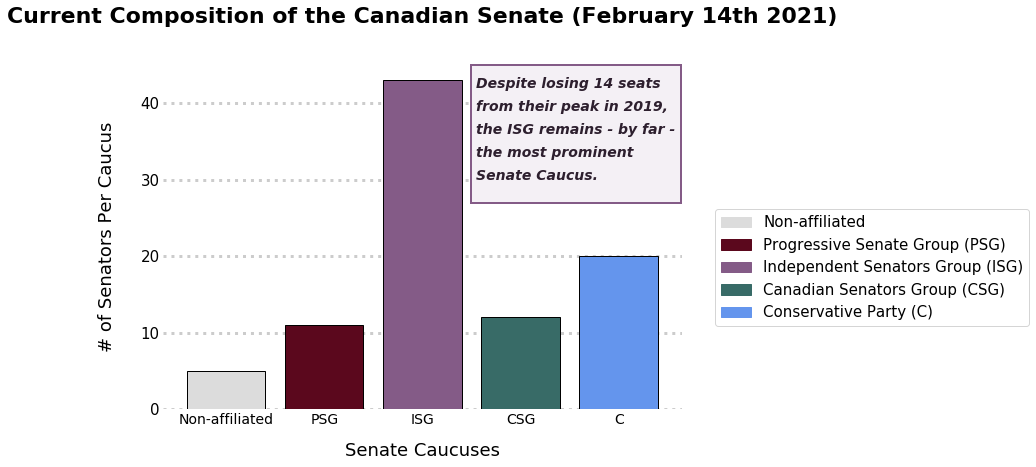

In [18]:
# Plotting the Caucus affiliations of current Senators as a simple bar plot:


# Setting tick sizes
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=15)


# Grabbing the data I need from the Dataframe to do a simple barplot:
afils = list(senators_today["Affiliation"].unique())
afil_counts = []
i = 0
for i in range(len(afils)):
    afil_counts += [senators_today[senators_today["Affiliation"] == afils[i]]["Name"].count()]

    
# Setting colours of the Senate Caucuses in the associated order that the above list "afils" is in:
afil_colors = ['#DCDCDC','#5B081D','#845B87','#386B67','#6495ED']


# Plot time!
fig = plt.figure()
ax = fig.add_axes([0,0,1.2,1.2])
ax.grid(axis = 'y', color = 'black', alpha = 0.2, linewidth = 3, linestyle= ':', zorder = 0)
ax.bar(afils,afil_counts, color = afil_colors, linewidth = 1, edgecolor = 'black', alpha=1, zorder = 3)


# Adding a legend because the senate caucus names are long and I want to write them in full next to the plot:
colors = {"Non-affiliated": "#DCDCDC", 'Progressive Senate Group (PSG)':'#5B081D', 'Independent Senators Group (ISG)':'#845B87', "Canadian Senators Group (CSG)" : "#386B67", "Conservative Party (C)" : "#6495ED"}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels,bbox_to_anchor=(1.05, 0.6), loc='upper left', fontsize=15, frameon=True)


# Setting title, background color and adding horizontal gridlines to the plot:
ax.set_title('Current Composition of the Canadian Senate (February 14th 2021)', y= 1.1, size=22).set_weight('bold')
ax.set_facecolor('white')
ax.tick_params(axis=u'both', which=u'both',length=0)
for spine in ax.spines:
    ax.spines[spine].set_visible(False)



# Draw rectangle
rect = ptches.Rectangle((2.5,27),2.13,18,linewidth=2,edgecolor='#845b87',facecolor='#f4f0f5', zorder=6)
ax.add_patch(rect)


# Add the annotations on the rectangle
ax.annotate('Despite losing 14 seats' , xy= (2.55,42), size= 14, color = "#2d1f2e", weight = 'bold', style='italic', zorder=9)
ax.annotate('from their peak in 2019,' , xy= (2.55,39), size= 14, color = "#2d1f2e", weight = 'bold', style='italic', zorder=9)
ax.annotate('the ISG remains - by far -' , xy= (2.55,36), size= 14, color = "#2d1f2e", weight = 'bold', style='italic', zorder=9)
ax.annotate('the most prominent' , xy= (2.55,33), size= 14, color = "#2d1f2e", weight = 'bold', style='italic', zorder=9)
ax.annotate('Senate Caucus.' , xy= (2.55,30), size= 14, color = "#2d1f2e", weight = 'bold', style='italic', zorder=9)


# Adding axis labels because I somehow forget to do that earlier
plt.ylabel("# of Senators Per Caucus", size= 18, labelpad = 25)
plt.xlabel("Senate Caucuses", size= 18, labelpad = 15)
plt.show()

In [19]:
# Sorting the data for a pie chart:
total_column = pd.DataFrame(data=senators_today.groupby("Affiliation").size()).rename(columns={0:"Total"})
Chretien_column = pd.DataFrame(data=senators_today[senators_today["Appointed on the advice of:"] == "Chrétien, Jean (Lib.)"].groupby("Affiliation").size()).rename(columns={0:"Chretien"})
Martin_column = pd.DataFrame(data=senators_today[senators_today["Appointed on the advice of:"] == "Martin, Paul (Lib.)"].groupby("Affiliation").size()).rename(columns={0:"Martin"})
Harper_column = pd.DataFrame(data=senators_today[senators_today["Appointed on the advice of:"] == "Harper, Stephen (C)"].groupby("Affiliation").size()).rename(columns={0:"Harper"})
Trudeau_column = pd.DataFrame(data=senators_today[senators_today["Appointed on the advice of:"] == "Trudeau, Justin (Lib.)"].groupby("Affiliation").size()).rename(columns={0:"Trudeau"})

all_columns = [Chretien_column, Martin_column, Harper_column, Trudeau_column]
all_columns_df = total_column.join(all_columns)
all_columns_df = all_columns_df[["Chretien","Martin","Harper","Trudeau","Total"]].fillna(0)
all_columns_df = all_columns_df.sort_values(by='Total', ascending=False)

all_columns_df

,Chretien,Martin,Harper,Trudeau,Total
Affiliation,,,,,
ISG,3.0,0.0,2.0,38.0,43
C,0.0,0.0,20.0,0.0,20
CSG,1.0,1.0,7.0,3.0,12
PSG,3.0,2.0,0.0,6.0,11
Non-affiliated,1.0,0.0,1.0,3.0,5


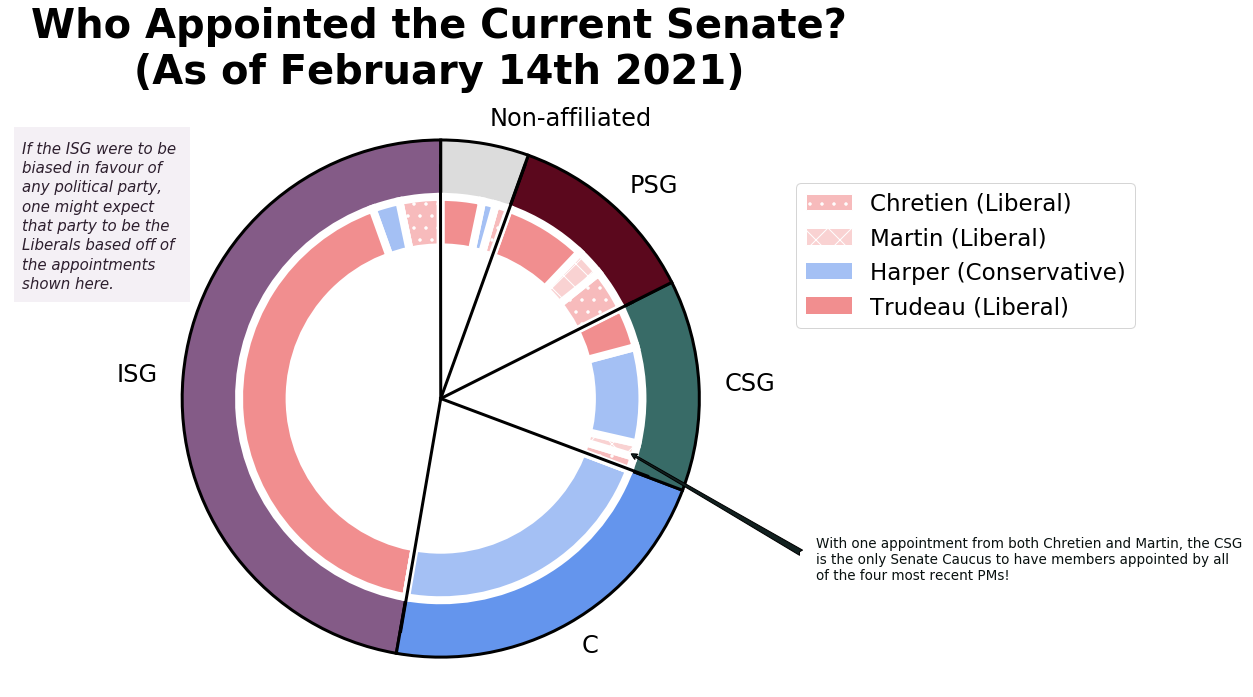

In [72]:
# I'm going to show the Senate as a nested pie chart with Caucuses being the outer ring,
# and the inner ring showing which Prime Minister appointed Senators who are now in the associated outer-ring Caucus 



# Starting the plot:
fig = plt.figure()
ax = fig.add_axes([0,0,2,2])


# Setting the data to be used for the outer ring of the nested pie chart:
labels = list(all_columns_df.index)
count = list(all_columns_df["Total"])
colours = ['#845B87','#6495ED','#386B67','#5B081D','#DCDCDC']

# Setting the data to be used for the inner ring:
labels_PMs = ["Chretien","Martin","Harper","Trudeau","Chretien","Martin","Harper","Trudeau","Chretien","Martin","Harper","Trudeau","Chretien","Martin","Harper","Trudeau","Chretien","Martin","Harper","Trudeau"]
pms = all_columns_df.columns[:-1]
cau = all_columns_df.index
count_PMs = []
for i in range(len(cau)):
    for j in range(len(pms)):
        count_PMs += [all_columns_df[pms[j]][cau[i]]]

chretien_colour = '#f7bbbc'
martin_colour = '#f9d2d2'
harper_colour ='#a4c0f4'
trudeau_colour = '#f18e8f'
colours_PMs = [chretien_colour, martin_colour, harper_colour, trudeau_colour, chretien_colour, martin_colour, harper_colour, trudeau_colour, chretien_colour, martin_colour, harper_colour, trudeau_colour, chretien_colour, martin_colour, harper_colour, trudeau_colour, chretien_colour, martin_colour, harper_colour, trudeau_colour]

# Setting the explosion levels of the ISG wedge and the subset of Trudeau appointments for that wedge for highlighting:
eo = 0
eo_isg = 0.05
explode_outer = (eo,eo,eo,eo,eo)
ei = 0
explode_inner = (ei,ei,ei,ei,ei,ei,ei,ei,ei,ei,ei,ei,ei,ei,ei,ei,ei,ei,ei,ei)

# Plotting the nested pie chart
outter = plt.pie(count, labels=labels, colors=colours, radius=1, startangle = 90, frame=True,  textprops={'fontsize': 24}, explode = explode_outer, wedgeprops={"edgecolor":"k",'linewidth': 3, 'linestyle': 'solid', 'antialiased': True})
inner = plt.pie(count_PMs, colors=colours_PMs, radius = 0.78, startangle=90, explode=explode_inner, wedgeprops={"edgecolor":"w",'linewidth': 8, 'linestyle': 'solid', 'antialiased': True})
centre_circle = plt.Circle((0,0),0.6,color='black',fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)


# Plotting the legend:
chretien_hatch = '.'
martin_hatch = 'x'
patch_chretien = ptches.Patch(facecolor=colours_PMs[0], hatch = chretien_hatch, label='Chretien (Liberal)', edgecolor = 'w')
patch_martin = ptches.Patch(facecolor=colours_PMs[1], hatch = martin_hatch, label='Martin (Liberal)', edgecolor ='w')
patch_harper = ptches.Patch(facecolor=colours_PMs[2],label='Harper (Conservative)')
patch_trudeau = ptches.Patch(facecolor=colours_PMs[3],label='Trudeau (Liberal)')
leg = plt.legend(handles = [patch_chretien, patch_martin, patch_harper, patch_trudeau], bbox_to_anchor=(0.9, 0.9), loc='upper left', fontsize=23)



# Plotting a 'text box'
plt.axis('equal')
rect = ptches.Rectangle((-1.65,0.375),0.68,0.675,linewidth=0,edgecolor='#845b87',facecolor='#f4f0f5')
ax.add_artist(rect)
plt.annotate('If the ISG were to be', xy=(-1.62,0.95), size=15, style='italic', color='#2d1f2e')
plt.annotate('biased in favour of', xy=(-1.62,0.875), size=15, style='italic', color='#2d1f2e')
plt.annotate('any political party,', xy=(-1.62,0.8), size=15, style='italic', color='#2d1f2e')
plt.annotate('one might expect', xy=(-1.62,0.725), size=15, style='italic', color='#2d1f2e')
plt.annotate('that party to be the', xy=(-1.62,0.65), size=15, style='italic', color='#2d1f2e')
plt.annotate('Liberals based off of', xy=(-1.62,0.575), size=15, style='italic', color='#2d1f2e')
plt.annotate('the appointments', xy=(-1.62,0.5), size=15, style='italic', color='#2d1f2e')
plt.annotate('shown here.', xy=(-1.62,0.425), size=15, style='italic', color='#2d1f2e')


# Add the title
plt.title('Who Appointed the Current Senate?\n(As of February 14th 2021)', size = 40, pad=30, weight='bold')


# Adding the hatch marks to the Chretien and Martin wedges:
criss_cross = inner[0]
criss_cross[8].set_hatch(chretien_hatch)
criss_cross[12].set_hatch(chretien_hatch)
criss_cross[16].set_hatch(chretien_hatch)
criss_cross[0].set_hatch(chretien_hatch)
criss_cross[9].set_hatch(martin_hatch)
criss_cross[13].set_hatch(martin_hatch)


# Adding dividing lines to the pie chart:
line_thicc = 3

plt.plot([-0.155, 0], [-0.9, 0], 'k-', lw=line_thicc)
plt.plot([-0.001, 0], [0.9, 0], 'k-', lw=line_thicc)
plt.plot([0.325, 0], [0.9, 0], 'k-', lw=line_thicc)
plt.plot([0.74, 0], [0.372, 0], 'k-', lw=line_thicc)
plt.plot([0.8, 0], [-0.3, 0], 'k-', lw=line_thicc)



# Annotating some additional fun facts:
ax.annotate("", size = 15, style = 'italic', 
            xy=(0.73, -0.21), 
            xytext=(1.4, -0.6),
            arrowprops=dict(arrowstyle="fancy", facecolor = '#122120',
                            connectionstyle="arc3"),
            )
plt.annotate("With one appointment from both Chretien and Martin, the CSG \nis the only Senate Caucus to have members appointed by all \nof the four most recent PMs!", 
             xy = (1.45, -0.7), size=13.5, color = "#091110"
            )



# That took a bit longer than I thought it would, oh well

plt.show()


In [73]:
# Creating a new Dataframe that shows all the current ISG Senators names

isg_sens = senators_today[senators_today["Affiliation"] == 'ISG'].reset_index(drop=True)
isg_sens = pd.DataFrame(isg_sens["Name"])
new_names = list(isg_sens["Name"])
names = []
i = 0
for i in range(len(new_names)):
    names += [new_names[i].split(' ')[0:2]]
    names[i][0] = names[i][0].replace(',','')
    names[i] = names[i][1] + ' ' + names[i][0]

    
isg_sens["Names"] = names
isg_sens = isg_sens.drop(columns='Name')
isg_sens["Names"][5] = "Frances Lankin"

# List of all the names
list_names = list(isg_sens["Names"])

# Creating some columns I'm going to fill with a function:
isg_sens["Initial Affiliation"] = np.nan
isg_sens["2nd Affiliation"] = np.nan
isg_sens["3rd Affiliation"] = np.nan
isg_sens["Current Affiliation"] = np.nan 
isg_sens = isg_sens.rename(columns={"Names":"Senators"})
isg_sens.set_index("Senators", inplace=True)

In [74]:
def update_isg_sens_df(Name):
    '''
    All this function does is it takes in the name of a current ISG Senator as a string formatted like: 'Firstname Lastname'
    and then updates the 'isg_sens' (ISG Senators) dataframe I have so that is shows the history of political affiliations
    for that senator.
    '''
    
    # Get info based on name:
    f_nam = Name.split(' ')[0]
    l_nam = Name.split(' ')[1]
    
    if Name == 'Margaret Anderson':    # Margaret Anderson and Eric Forest had webpages that were formatted differently...
        url = 'https://lop.parl.ca/ParlinfoWebAPI/Person/SearchAndRefine?callback=jQuery33106434539965756902_1608063114447&expression=Margaret%7CDawn%7CAnderson&refiners=&_=1608063114449'
    else:
        url = f'https://lop.parl.ca/ParlinfoWebAPI/Person/SearchAndRefine?callback=jQuery33106434539965756902_1608063114447&expression={f_nam}%7C{l_nam}&refiners=&_=1608063114449'

    res = requests.get(url)
    html_page = res.content
    soup = BeautifulSoup(html_page, 'html.parser')
    text = soup.find_all(text=True)
    
    # Filter info and translate into English:
    if Name == 'Éric Forest':                   # for some reason Eric Forest's webpage was formatted differently :(
        a = "".join(text[0:])
        eric_key = a.find('StraightDisplayName":"Éric Forest"')
        a = a[eric_key:]
        eric_key2 = a.find('"PartyFr"') 
        afil_history = a[eric_key2+11:eric_key2+300]
        afil_history = afil_history.split('ConstituencyEn')[0]
        afil_history = afil_history[:-3].replace('Non-affilié(e) (Groupe des sénateurs indépendants)','ISG').replace('Indépendant','Independent').replace('Non affilié(e)','Non-affiliated')
        afil_history = afil_history.replace('Parti conservateur du Canada','Conservative Party').replace('Groupe des sénateurs indépendants','Independent Senators Group').replace('Parti libéral du Canada','Liberal Party')
  
    else:
        afil_history = "".join(text[1:len(text)-7]).split("PartyFr")[1][3:].replace('Non-affilié(e) (Groupe des sénateurs indépendants)','ISG').replace('Indépendant','Independent').replace('Non affilié(e)','Non-affiliated')
        afil_history = afil_history.replace('Parti conservateur du Canada','Conservative Party').replace('Groupe des sénateurs indépendants','Independent Senators Group').replace('Parti libéral du Canada','Liberal Party')

    # This is to deal with people who were MPs before they were Senators and Eric Forest for some reason:
    if 'ConstituencyEn' in afil_history:
        afil_history = afil_history.split('ConstituencyEn')[0]
        afil_history = afil_history[:-3]

    
    
    # This is to deal with duplicate entries of ISG and Independent Senators Group
    if 'Independent Senators Group' in afil_history and 'ISG' in afil_history:
  
        isg_key = afil_history.index('ISG')
        isg_date = afil_history[isg_key+4:isg_key+15] + ' - )'
        afil_history = afil_history[0:isg_key] + afil_history[isg_key+29:]
        indepen_sen_gr_key =  afil_history.index('Independent Senators Group')
        afil_history = afil_history[indepen_sen_gr_key:indepen_sen_gr_key+27] + isg_date + afil_history[indepen_sen_gr_key+42:]
    
    
    # And this is to deal with duplicate entries of non-affiliated:
    if 'Non-affiliated' in afil_history and 'Independent (' in afil_history:
    
        ind_key = afil_history.index('Independent (')
        ind_date = afil_history[ind_key+12:ind_key+23]
        afil_history = afil_history[0:ind_key] + afil_history[ind_key+37:]
        non_key = afil_history.index('Non-affiliated')
        afil_history = afil_history[0:non_key+15] + ind_date + afil_history[non_key+26:]
    

    
    
    # Re-sorting all their historical senate affiliations into a list!
    afil_history = afil_history.replace(')',')*').split('*')
    afil_history = afil_history[:-1]



    # Sending the values to the dataframe:
    i = 0
    for i in range(len(afil_history)-1):
        if i == 0:
            isg_sens.loc[f'{f_nam} {l_nam}', "Initial Affiliation"] = afil_history[-1]
        if i == 1:
            isg_sens.loc[f'{f_nam} {l_nam}', "2nd Affiliation"] = afil_history[len(afil_history)-1-i]
        if i == 2:
            isg_sens.loc[f'{f_nam} {l_nam}', "3rd Affiliation"] = afil_history[len(afil_history)-1-i]

    isg_sens.loc[f'{f_nam} {l_nam}', "Current Affiliation"] = afil_history[0]



In [75]:
for i in range(len(list_names)):
    update_isg_sens_df(list_names[i])

In [76]:
# Just making a pretty dataframe to show changes in affiliation among ISG Senators over the years...

isg_sens = isg_sens.fillna('N/A')

def colour_red(val):
    is_liberal = val.str.contains("Liberal Party") 
    return ['background-color: #f18e8f' if v else '' for v in is_liberal]

def colour_blue(val):
    is_con = val.str.contains("Conservative Party") 
    return ['background-color: #a4c0f4' if v else '' for v in is_con]

def colour_grey(val):
    is_non = val.str.contains("Non-affiliated")
    return ['background-color: #DCDCDC' if v else '' for v in is_non]

def colour_white(val):
    is_na = val.str.contains("N/A")
    return ['background-color: white' if v else '' for v in is_na]

def colour_purple(val):
    is_ind = val.str.contains("Group")
    return ['background-color: #bfa4c1' if v else '' for v in is_ind]


def show_styled_df(df, RowsToShow = 8, Minimize = True):
    if Minimize == True:
        df_styled = df.head(RowsToShow).style.apply(colour_red).apply(colour_blue).apply(colour_grey).apply(colour_white).apply(colour_purple)
    if Minimize == False:
        df_styled = df.style.apply(colour_red).apply(colour_blue).apply(colour_grey).apply(colour_white).apply(colour_purple)
    return df_styled

show_styled_df(isg_sens, 10, Minimize = False)

,Initial Affiliation,2nd Affiliation,3rd Affiliation,Current Affiliation
Senators,,,,
Mobina Jaffer,Liberal Party (2001/06/13 - 2018/12/18),Non-affiliated (2018/12/19 - 2019/06/11),N/A,Independent Senators Group (2019/06/12 - )
Pierrette Ringuette,Liberal Party (1993/10/25 - 1997/06/01),Liberal Party (2002/12/12 - 2016/02/01),Non-affiliated (2016/02/02 - 2016/12/01),Independent Senators Group (2016/12/02 - )
Paul Massicotte,Liberal Party (2003/06/26 - 2017/10/29),N/A,N/A,Independent Senators Group (2017/10/30 - )
Michael Duffy,Conservative Party (2009/01/02 - 2013/05/15),Non-affiliated (2013/05/16 - 2016/12/01),N/A,Independent Senators Group (2016/12/02 - )
Diane Bellemare,Conservative Party (2012/09/06 - 2016/03/07),Non-affiliated (2016/03/08 - 2019/11/13),N/A,Independent Senators Group (2019/11/14 - )
Frances Lankin,Non-affiliated (2016/04/01 - 2016/12/01),N/A,N/A,Independent Senators Group (2016/12/02 - )
Ratna Omidvar,Non-affiliated (2016/04/01 - 2016/12/01),N/A,N/A,Independent Senators Group (2016/12/02 - )
Chantal Petitclerc,Non-affiliated (2016/04/01 - 2016/12/01),N/A,N/A,Independent Senators Group (2016/12/02 - )
Marilou McPhedran,Non-affiliated (2016/11/10 - 2016/12/01),N/A,N/A,Independent Senators Group (2016/12/02 - )


### The coloured dataframe and the nested pie chart tell two different stories. 


#### On one hand, the nested pie chart implies that the ISG might be biased towards favouring the Liberals based on the fact that most ISG members were appointed by Trudeau, a Liberal.


#### On the other hand, the coloured dataframe shows that most ISG members were initially Non-affiliated (although many of them only for a short period of time) before they joined the ISG.

I feel that these two visualizations capture the essence of my research questions: is the ISG non-partisan? Or is it ["Liberals masked as independents?"](https://www.cbc.ca/news/politics/stefanovich-senate-reforms-trudeau-1.5187149) 


We will now delve into the data and try to answer this question.

<h2><center>Part One:</center></h2>

### For Bills that originate in the Senate and are sponsored by a member of the ISG, if the Bill reaches the House of Commons is any one party more likely to vote in favour (Yea) of the Bill compared to other parties – if so, how much more likely and which party?

In [77]:
# First we need to filter HOC votes for votes that were on Senate Bills

def which_HOC_votes_were_on_senate_bills(Parliament, Session):
    '''
    
    This function takes in a Parliament as an int (from 38 to 43) and a Session as an int (from 1 to 3, although not every 
    Parliament has more than 1 Session). 
    
    The function then returns a dataframe that shows every vote on Senate Public Bills and Senate Government Bills
    in the House of Commons for that Parliament & Session.    
    
    
    '''
    
    url = f'https://www.ourcommons.ca/members/en/votes?parlSession={Parliament}-{Session}#'
    
    parliament_and_session = [f'{Parliament} / {Session}']
    
    
    all_votes = pd.read_html(url)
    all_votes = all_votes[0]
    a = all_votes[all_votes["Vote Respecting"] == "Senate Government Bill"]
    b = all_votes[all_votes["Vote Respecting"] == "Senate Public Bill"]
    
    c = a.append(b).reset_index(drop=True)
    
    parliament_and_session = parliament_and_session*len(c)
    
    c["Parliament / Session"] = parliament_and_session
    
    return c
    




#### Because the ISG was only formed in [March 2016](https://www.isgsenate.ca/milestones) we only need to worry about getting House of Commons votes on Senate Bills starting from the 42nd Parliament which commenced on December 3rd, 2015.





In [78]:
# Getting the dataframes of House of Commons votes on Senate Bills for Parliamentary Sessions going back to Dec.3 2015:
parl_43_2 = which_HOC_votes_were_on_senate_bills(43,2)
parl_43_1 = which_HOC_votes_were_on_senate_bills(43,1)
parl_42_1 = which_HOC_votes_were_on_senate_bills(42,1)


# Putting all those those dataframes together to give us all the information in one dataframe:
all_sessions = [parl_43_2, parl_43_1, parl_42_1]
parl_43_and_42 = pd.concat(all_sessions)


# Setting the Date column to datetime so I can filter later:
parl_43_and_42['Date'] = pd.to_datetime(parl_43_and_42['Date'])


# Fixing the name of a column:
parl_43_and_42 = parl_43_and_42.rename(columns={"Vote\xa0Number": "Vote Number"})


# This code is just to get the number, and nothing else, of votes in House on Senate Bills from the 42nd to 43rd Parliament
vote_numbers  = list(parl_43_and_42["Vote Number"]) 
i = 0
vote_nums_only = []
for i in range(len(parl_43_and_42)):
    vote_nums_only += [vote_numbers[i][4:]]
    
    
# Sorting by the Vote number:
parl_43_and_42["Vote Number"] = vote_nums_only
parl_43_and_42["Vote Number"] = pd.to_numeric(parl_43_and_42["Vote Number"]) 
parl_43_and_42 = parl_43_and_42.sort_values(by='Vote Number', ascending = False).reset_index(drop = True)


# Filtering the dataframe for votes starting March 2016, after the creation of the ISG:
parl_43_and_42 = parl_43_and_42[(parl_43_and_42['Date'] > '2016-02-28')]


# Filtering for only votes on 2nd readings:
parl_43_and_42_2nd_readings = parl_43_and_42[parl_43_and_42['Subject'].str.contains("2nd reading")].reset_index(drop=True)


# Getting just the Bill's number:
i = 0
bill_nums_only = []
for i in range(len(parl_43_and_42_2nd_readings)):
    bill_nums_only += [parl_43_and_42_2nd_readings["Subject"].str.split("2nd reading of Bill S-")[i][1].split(",")[0]]

parl_43_and_42_2nd_readings["Bill S-"] = bill_nums_only


# Display full dataframe:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'max_colwidth', -1):
    display(parl_43_and_42_2nd_readings)

,Vote Number,Vote Respecting,Subject,Votes (Yeas/ Nays / Paired),Vote Result,Date,Parliament / Session,Bill S-
0,1325,Senate Public Bill,"2nd reading of Bill S-243, An Act to amend the Canada Revenue Agency Act (reporting on unpaid income tax)",134 / 150 / 2,Negatived,2019-05-29,42 / 1,243
1,1293,Senate Public Bill,"2nd reading of Bill S-215, An Act to amend the Criminal Code (sentencing for violent offences against Aboriginal women)",45 / 237 / 8,Negatived,2019-04-10,42 / 1,215
2,902,Senate Public Bill,"2nd reading of Bill S-245, An Act to declare the Trans Mountain Pipeline Project and related works to be for the general advantage of Canada",86 / 197 / 2,Negatived,2018-10-24,42 / 1,245
3,649,Senate Public Bill,"2nd reading of Bill S-210, An Act to amend An Act to amend the Immigration and Refugee Protection Act, the Civil Marriage Act and the Criminal Code and to make consequential amendments to other Acts",293 / 1 / 0,Agreed To,2018-04-18,42 / 1,210
4,452,Senate Public Bill,"2nd reading of Bill S-228, An Act to amend the Food and Drugs Act (prohibiting food and beverage marketing directed at children)",220 / 86 / 2,Agreed To,2018-02-14,42 / 1,228
5,377,Senate Public Bill,"2nd reading of Bill S-230, An Act to amend the Criminal Code (drug-impaired driving)",127 / 163 / 2,Negatived,2017-10-25,42 / 1,230
6,208,Senate Public Bill,"2nd reading of Bill S-217, An Act to amend the Criminal Code (detention in custody)",154 / 128 / 2,Agreed To,2017-03-08,42 / 1,217
7,200,Senate Public Bill,"2nd reading of Bill S-211, An Act respecting National Sickle Cell Awareness Day",294 / 0 / 0,Agreed To,2017-02-15,42 / 1,211
8,142,Senate Public Bill,"2nd reading of Bill S-208, An Act respecting National Seal Products Day",283 / 3 / 0,Agreed To,2016-11-02,42 / 1,208
9,139,Senate Public Bill,"2nd reading of Bill S-201, An Act to prohibit and prevent genetic discrimination",311 / 0 / 0,Agreed To,2016-10-26,42 / 1,201


#### A quick note on why I filtered the dataframe to only include votes on the 2nd reading of a Senate Bill:
>This is because if the Senate Bill passes 2nd reading, before it goes to 3rd reading, it goes to Committee Stage and Report Stage where MPs can make amendments to the Bill; my concern is that votes on report stage amendments and 3rd readings will not be fully reflective of any relationship between a political party in the House of Commons and a caucus in the Senate, but rather votes at this stage will reflect relationships between political parties within the House of Commons.


Now that I have the subset of House of Commons votes I want to analyze, **I need a function that will gather detailed information on each vote that may be relevant to my analysis, including data on**: 
- the caucus/party affiliation (at the time of introduction) of the Senator who first introduced the Bill in the Senate ;
- the party affiliation of the MP who sponsored the motion of the 2nd reading and; 
- all the votes (Yea/Nay) made by MPs and their associated political parties. 






The following cell defines a function that takes in a Vote Number and returns a dataframe with much more information than is given on the regular House of Commons 'Vote Detail' table. Specifically the information I add to it is: Sex of the MP, Riding (seperate it from the name of MP), HOC Sponsor's Affiliation, Senate Sponsor's Affiliation (at time of introduction).

In [79]:
def get_house_votes_on_senate_bill(VoteNumber, Parliament = 42, Session = 1, Sex = False):
    '''
    This function takes in a Vote Number, Parliament, and Session, all as integers.
    
    It also takes in an optional boolean for Sex; if Sex is set to to True then the sex of the MPs will be included as a 
    column in the resulting dataframe.
    
    This function is actually flexible: it can handle vote detail pages from the House of Commons for on Bills that 
    originate from the House of Commons OR from the Senate (but it does not handle votes on motions which are not directly 
    related to a Bill). 
    
    For our purposes we are more interested in vote outcomes that pertain to Bills that originate in the Senate, but it can
    also take vote detail pages that are for House Bills.
    
    If the Bill originated in the Senate, additional information will be pulled from the associated LEGISInfo website and added
    to the dataframe. If not, then any additional information from LEGISInfo will be ignored and the resulting dataframe will 
    remain comparatively simple.    
    '''
    
    # Getting the voting record on a motion (and renaming one column so it isn't 2 sentences long) 
    url = f'https://www.ourcommons.ca/members/en/votes/{Parliament}/{Session}/{VoteNumber}'
    table = pd.read_html(url)
    table = table[0]
    table = table.rename(columns={"Paired Two members from opposite sides of the House can agree to neutralize their votes by abstaining from voting on a given day, allowing them to be absent from the House." : "Paired"})
    
    
    # Now I want to seperate the name of the MP from their riding and add the riding as a seperate column
    table = table.join(table['Member of Parliament'].str.split('(', expand=True).add_prefix('Riding'))
    
    
    # Cleaning the dataframe
    table = table.drop(columns=["Member of Parliament"])
    table = table.rename(columns={"Riding1":"Riding", "Riding0": "Member of Parliament"})
    table['Riding'] = table['Riding'].str.slice_replace(-1)
    
    
    # Also, let's grab the sex of the MPs while we're here (optional):
    if Sex == True:
        table = table.join(table['Member of Parliament'].str.split('.', expand=True).add_prefix('Sex'))
        table = table.drop(columns=["Sex1","Sex2"])
        table = table.rename(columns={"Sex0" : "Sex of MP"})
        table['Sex of MP'] = table['Sex of MP'].replace('Mr','Male')
        table['Sex of MP'] = table['Sex of MP'].replace('Ms','Female')
        table['Sex of MP'] = table['Sex of MP'].replace('Mrs','Female')
        
    
    # In order to get some additional information from the House of Commons (HOC) Votes website I need to convert all the text
    # to a list
    res = requests.get(url)
    html_page = res.content
    soup = BeautifulSoup(html_page, 'html.parser')
    text = soup.find_all(text=True)
    
    
    # Getting the Party of the HOC sponsor:
    
    # Because the Votes pages are all formatted the same, taking the value at the index location of 686 of 'text'
    # (or 685 if the MP does not have the title of "The Honourable") will work out 
    # to be the Party to which the sponsoring member belongs to 
    
    if "The Honourable" in text:
        z = 686
    else:
        z = 685
    
    sponsor_party_in_HOC = [text[z]]
    sponsor_party_in_HOC = sponsor_party_in_HOC*len(table)
    table["Sponsor's Party (HOC)"] = sponsor_party_in_HOC
    
    
    # Ok, now I want to get the affiliation of the Sponsor in the Senate for bills that originate in the Senate:
    # To do this, I need the Parliament and Session number as well as the number of the Bill:
    key = text.index("Bill Sponsor:") - 5
    bill = text[key].split(' ')[1] 
    
    if 'S' in bill:  # This loop gives us the bill number and then adds a column if the Bill originated in the Senate
        bill_num = [bill.split('S-')[1]]   
        
        # Using the Parliament and Session and Bill numbers we can now search the LEGISInfo website for more info:
        
        url2 = f"https://www.parl.ca/LegisInfo/Result.aspx?BillNumber={bill_num}&ParliamentSession={Parliament}-{Session}&OriginatingChamber=Senate&Language=E&Mode=1"

        res2 = requests.get(url2)
        html_page2 = res2.content
        soup2 = BeautifulSoup(html_page2, 'html.parser')
        text2 = soup2.find_all(text=True)
        senate_sponsors_affiliation = [text2[242].split('\r')[0]] * len(table)  
        table["Senate Sponsor's Affiliation (at introduction)"] = senate_sponsors_affiliation
        table["Senate Sponsor's Affiliation (at introduction)"] = table["Senate Sponsor's Affiliation (at introduction)"].replace('Independent','Non-affiliated')
        
    
        if Sex == True:
            table = table[["Riding", "Sex of MP","Member of Parliament","Political Affiliation", "Member Voted", "Sponsor's Party (HOC)", "Senate Sponsor's Affiliation (at introduction)", "Paired"]]
        else:
            table = table[["Riding", "Member of Parliament","Political Affiliation", "Member Voted", "Sponsor's Party (HOC)", "Senate Sponsor's Affiliation (at introduction)", "Paired"]]
        
    else:
        bill_num = bill.split('C-')[1]
        
        if Sex == True:
            table = table[["Riding", "Sex of MP", "Member of Parliament","Political Affiliation", "Member Voted", "Sponsor's Party (HOC)", "Paired"]]
        else:
             table = table[["Riding", "Member of Parliament","Political Affiliation", "Member Voted", "Sponsor's Party (HOC)", "Paired"]]
        
    
    return table

In [80]:
# Getting all the Vote Number's to put into my new function get_house_votes_on_senate_bills:
vote_number_list = list(parl_43_and_42_2nd_readings["Vote Number"])


# Creating the keys for what will be the concatenated dataframe of all relevant vote numbers put through the function:
bil = list(parl_43_and_42_2nd_readings["Bill S-"])
bil_s = []
for x in bil:
    bil_s += [f'Bill S-{x}']

    
# Creating a dictionary of dataframes, one dataframe for each associated vote number!    
d = {x: get_house_votes_on_senate_bill(x, Sex = True) for x in vote_number_list}


# Merging all the dataframes from the dictionary into one dataframe:
all_HOC_votes_on_senate_bills = pd.concat(d.values(), keys = bil_s)

# Displaying just votes on Senate Bills that were sponsored in the Senate by an ISG Senator:
with pd.option_context('display.max_rows', 8, 'display.max_columns', None, 'max_colwidth', -1):
    display(all_HOC_votes_on_senate_bills)

Riding Sex of MP  \
Bill S-243 0    Edmonton Manning                            Male       
           1    Central Okanagan—Similkameen—Nicola         Male       
           2    Kitchener—Conestoga                         Male       
           3    Cloverdale—Langley City                     Male       
...                                 ...                      ...       
Bill S-201 307  Etobicoke Centre                            Male       
           308  London West                                 Female     
           309  Fort McMurray—Cold Lake                     Male       
           310  Prince George—Peace River—Northern Rockies  Male       

                  Member of Parliament Political Affiliation Member Voted  \
Bill S-243 0    Mr. Ziad Aboultaif      Conservative          Yea           
           1    Mr. Dan Albas           Conservative          Yea           
           2    Mr. Harold Albrecht     Conservative          Yea           
           3    Mr. John Aldag          Liberal               Nay           
...                        ...              ...               ...           
Bill S-201 307  Mr. Borys Wrzesnewskyj  Liberal               Yea           
           308  Ms. Kate Young          Liberal               Yea           
           309  Mr. David Yurdiga       Conservative          Yea           
           310  Mr. Bob Zimmer          Conservative          Yea           

               Sponsor's Party (HOC)  \
Bill S-243 0    Conservative           
           1    Conservative           
           2    Conservative           
           3    Conservative           
...                      ...           
Bill S-201 307  Liberal                
           308  Liberal                
           309  Liberal                
           310  Liberal                

               Senate Sponsor's Affiliation (at introduction) Paired  
Bill S-243 0    Liberal                                        NaN    
           1    Liberal                                        NaN    
           2    Liberal                                        NaN    
           3    Liberal                                        NaN    
...                 ...                                        ...    
Bill S-201 307  Liberal                                        NaN    
           308  Liberal                                        NaN    
           309  Liberal                                        NaN    
           310  Liberal                                        NaN    

[2930 rows x 8 columns]

**So, unfortunately, it turns out that there has only been one Senate Bill which was originally introduced by a member of the ISG that made it to a 2nd reading vote in the House of Commons.**

**This makes any analysis from the vote results on this Bill extremely dubious as the sample size is, in a sense, 
n = 1.**

**Nevertheless, let's go ahead and plot the results anyways just to see how the different parties in the HOC voted at 2nd readings of Senate Bills for the 42 & 43 Parliament (to date).**

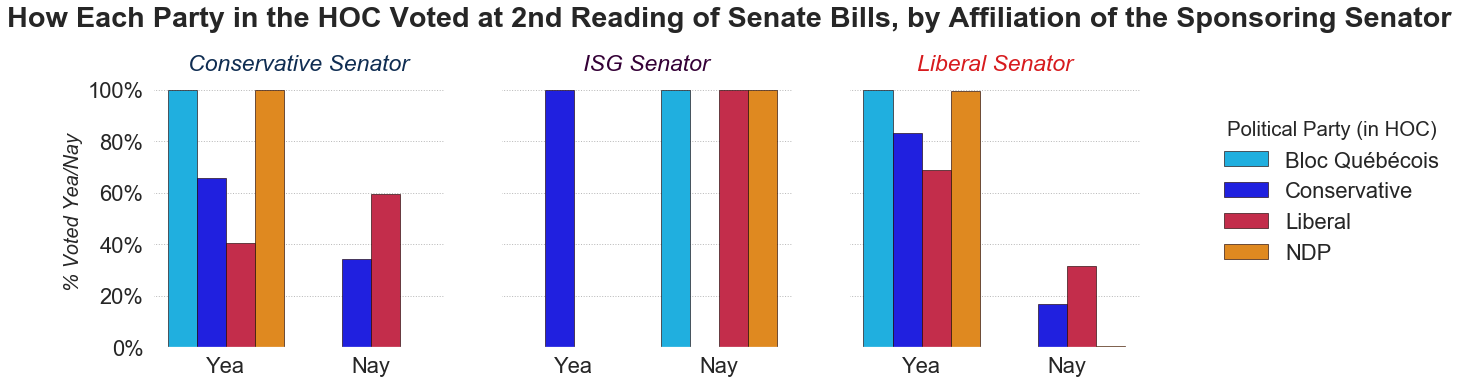

In [81]:
# Getting rid of some of the information that isn't pertinent to our analysis:

cleaned_all_HOC_votes_on_senate_bills = all_HOC_votes_on_senate_bills.drop(columns=["Riding","Sex of MP", "Member of Parliament", "Paired"])
cleaned_all_HOC_votes_on_senate_bills = cleaned_all_HOC_votes_on_senate_bills.dropna() # this only drops 18 rows, and is for rows where a MP did not vote - this analysis is more concerned with Yeas and Nays, not abstentions
cleaned_all_HOC_votes_on_senate_bills = cleaned_all_HOC_votes_on_senate_bills[cleaned_all_HOC_votes_on_senate_bills["Political Affiliation"].str.contains("Conservative|Liberal|NDP|Bloc Québécois")]
cleaned_all_HOC_votes_on_senate_bills = cleaned_all_HOC_votes_on_senate_bills.rename(columns={"Political Affiliation" : "Political Party (in HOC)"})
# The previous line just removes the rows associated with votes cast by an MP who is not (at the time of voting) a member
# of any of the 4 major political parties (BQ, NDP, Liberal, Conservative). This results in losing 29 rows from the dataframe.


# re-format
second_reading_series_sen = cleaned_all_HOC_votes_on_senate_bills.groupby(by=["Senate Sponsor's Affiliation (at introduction)", "Political Party (in HOC)", "Member Voted"]).size()
second_reading_series_sen = second_reading_series_sen.astype('float')


# convert everything in terms of % voted Yea/Nay for each political party conditional on the caucus affiliation of the Senator
# who introduced the Bill originally in the Senate:
sen_sponsor_afil = ['Conservative', 'Independent Senators Group', 'Liberal']
pol_afil = ['Bloc Québécois', 'Conservative', 'Liberal', 'NDP']
i = 0
j = 0
tot_vot = []
for i in range(0,3):
    for j in range(0,4):
        tot_vot.append(second_reading_series_sen[sen_sponsor_afil[i]][pol_afil[j]].sum())
        
i = 0
j = 0
tot_vot_2 = [tot_vot[0:4],tot_vot[4:8],tot_vot[8:12]]
for i in range(0,3):
    for j in range(0,4):
        second_reading_series_sen[sen_sponsor_afil[i]][pol_afil[j]] = second_reading_series_sen[sen_sponsor_afil[i]][pol_afil[j]] / tot_vot_2[i][j]


# Getting ready to plot all the data
second_reading_df_sen = pd.DataFrame(data=second_reading_series_sen)
second_reading_df_sen = second_reading_df_sen.rename(columns={0: "Vote Count"})
second_reading_df_sen = second_reading_df_sen.reset_index()


# Plotting:
colour_parties = {"Bloc Québécois" : "deepskyblue", "Conservative" : "blue", "Liberal" : "crimson", "NDP" : "darkorange"}

sns.set(font_scale=2)
g = sns.catplot(x="Member Voted", y="Vote Count", hue="Political Party (in HOC)", col="Senate Sponsor's Affiliation (at introduction)", kind="bar", data=second_reading_df_sen, palette = colour_parties, edgecolor = '#1a0000' , linewidth = 0.6)


axes = g.axes.flatten()

axes[0].set_title("Conservative Senator", fontsize = 23, color='#0F2D52').set_style('italic')
axes[1].set_title("ISG Senator", fontsize = 23, color= "#340036").set_style('italic')
axes[2].set_title("Liberal Senator", fontsize = 23, color = "#D71B1E").set_style('italic')
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
axes[0].set_ylabel('% Voted Yea/Nay', fontsize = 20).set_style('italic')


sen_colors = ["#0F2D52","#340036","#D71B1E"]


i = 0
for i in range(0,3):
    axes[i].set_xlabel('')
    axes[i].set_facecolor('#ffffff')
    axes[i] = axes[i].grid(axis = 'y', color = 'k', alpha = 0.3, linestyle= ':')
    


plt.suptitle('How Each Party in the HOC Voted at 2nd Reading of Senate Bills, by Affiliation of the Sponsoring Senator', y = 1.1).set_weight('bold')


Although the sample size makes the results shown in the graph above doubtful in terms of future predictive power, it is interesting to note that the Liberals voted entirely Nay and the Conservatives voted entirely Yea for the one ISG-sponsored Senate Bill; this is the opposite of what one might expect after looking at the nested pie chart visualization I made earlier.

In [82]:
# I am now going to use a Random Forest Model to predict HOC votes by each MP on ISG Bills.

# Making a dataframe for just HOC Votes on ISG Sponsored Bills (so just the one) and re-formatting the 
# "Member Voted" Column so that Yea=1 and Nay=0

isg_hoc_votes = all_HOC_votes_on_senate_bills[all_HOC_votes_on_senate_bills["Senate Sponsor's Affiliation (at introduction)"] == "Independent Senators Group"]
isg_hoc_votes = isg_hoc_votes[isg_hoc_votes["Political Affiliation"].str.contains("Liberal|NDP|Conservative|Bloc Québécois")]
isg_hoc_votes["Member Voted"] = isg_hoc_votes["Member Voted"].replace("Yea", 1).replace("Nay", 0)
isg_hoc_votes = isg_hoc_votes.set_index("Member of Parliament").drop(columns="Paired").dropna()

# If we had data for multiple ISG Senate Bills and many years then riding might be a good variable to use, but in our case
# we have as many unique values for Riding as the length of the Dataframe, so it's kind of useless for our purpose

isg_hoc_votes = isg_hoc_votes.drop(columns=["Riding"]) 
isg_hoc_votes["Member Voted"] = isg_hoc_votes["Member Voted"].astype(int)



# This is just to encode all the categorical data:

def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

res = encode_and_bind(isg_hoc_votes, 'Sex of MP')
res = encode_and_bind(res, 'Political Affiliation')
res = encode_and_bind(res, "Sponsor's Party (HOC)")
res = encode_and_bind(res, "Senate Sponsor's Affiliation (at introduction)")


# Okay, now onto training and testing the Random Forest Model:

res = res.sample(frac=1)                  # randomizing the sample to be trained and tested on
predic = 139
Y_train = res["Member Voted"][:predic]     # training on 50% of the data
Y_test = res["Member Voted"][predic:]
X_train = res.drop(columns=["Member Voted"])[:predic]        # testing on the other 50%
X_test = res.drop(columns=["Member Voted"])[predic:]

forest = RandomForestRegressor(n_estimators = 100).fit(X_train,Y_train)
forest_predictions = forest.predict(X_test)
results = pd.DataFrame(Y_test)
results["Forest Predictions"] = forest_predictions
print(f"This shows the number of correct preidctions made, where True indicates a correct prediction, \nand False indicates an incorrect prediction:\n\n{(forest_predictions == Y_test).value_counts()}\n\n----------------------------------------------------------------------------------------------------------")
print(f"This is the Random Forest's feature importances array: {forest.feature_importances_}\n\nAs we can see on the dataframe below, this corresponds to the 'Political Affiliation_Conservative' column, \nmeaning that all the predictive power stems from this column.")
X_train.head(2)


This shows the number of correct preidctions made, where True indicates a correct prediction, 
and False indicates an incorrect prediction:

True    139
Name: Member Voted, dtype: int64

----------------------------------------------------------------------------------------------------------
This is the Random Forest's feature importances array: [0. 0. 0. 1. 0. 0. 0. 0.]

As we can see on the dataframe below, this corresponds to the 'Political Affiliation_Conservative' column, 
meaning that all the predictive power stems from this column.


,Sex of MP_Female,Sex of MP_Male,Political Affiliation_Bloc Québécois,Political Affiliation_Conservative,Political Affiliation_Liberal,Political Affiliation_NDP,Sponsor's Party (HOC)_Conservative,Senate Sponsor's Affiliation (at introduction)_Independent Senators Group
Member of Parliament,,,,,,,,
Mr. Stephen Fuhr,0,1,0,0,1,0,1,1
Ms. Karen Ludwig,1,0,0,0,1,0,1,1


While Random Forests are usually very hard to interpret, this particular model is comparatively straightforward. All the predictive power starts with whether or not the MP is a Conservative Party member.

***This model would indicdate that being a Conservative Party member increases the likelihood that an MP will vote (Yea) in favour of an ISG Sponsored Senate Bill, while NOT being a Conservative party member increases the likelihood that an MP will vote (Nay) against an ISG Sponsored Senate Bill.*** 

As noted before there has only been one ISG Sponsored Senate Bill that made it to a 2nd reading vote in the House of Commons so the results from this Random Forest Model are ****extremely**** suspect. In order to further investigate any political bias in the ISG we must now look to voting patterns in the Senate itself:

<h2><center>Part Two:</center></h2>

### For Bills that originate in the House of Commons, if they are introduced by a member of a specific political party, e.g. the Liberals, are ISG members more likely to vote against this Bill? 
>*I.e. does the political affiliation of the Member of Parliament who introduced the Bill hold predictive power in determining whether or not ISG members will vote against (or in favour of) the Bill?*

I'll start here by seaching the Senate website to find which Senate votes were on 2nd readings of House of Commons Bills

In [83]:
def which_senate_votes_were_on_2nd_readings_of_house_bills(Parliament, Session):

    url = f'https://sencanada.ca/en/in-the-chamber/votes/{Parliament}-{Session}'
    df = pd.read_html(url)
    df = df[0]
    df = df.fillna('None')
    df = df[df["Related Bill"].str.contains("C")]
    df = df[df["Title"].str.contains("Second")]
    return df

In [84]:
# Getting all Senate votes on 2nd readings of HOC Bills from the start of the 42nd Parliament till now:
a = which_senate_votes_were_on_2nd_readings_of_house_bills(42,1)
b = which_senate_votes_were_on_2nd_readings_of_house_bills(43,1)
c = which_senate_votes_were_on_2nd_readings_of_house_bills(43,2)
abc = [a,b,c]
df = pd.concat(abc)

# Filtering out adjournments of debate and one 2nd reading Amendment:
drop = df[(df["Title"].str.contains("Amendment")) | df["Title"].str.contains("Adjournment of Debate")].index
for i in range(len(drop)):
    df = df.drop([drop[i]])
df = df.sort_values(by='Date', ascending=False).reset_index(drop=True)

Now that I have a dataframe of all the Senate votes on 2nd readings of House of Commons Bills, I can use the 'Title' column to search the Senate website for the urls for the 'Vote Detail' pages so I can start gathering all the information required to examine voting patterns.

In [85]:
def get_vote_urls(Parliament, Session):
    '''
    This fucntion finds the url (or the last half anyways) for the 'Vote Detail' pages associated with each Senate vote.
    It squishes everything into one big string so we'll have to still root through here to find the exact url and match them
    to the right vote.
    '''
    url = f'https://sencanada.ca/en/in-the-chamber/votes/{Parliament}-{Session}'
    headers = {'User-Agent': 'Mozilla/5.0'}
    page = requests.get(url, headers=headers)

    soup = BeautifulSoup(page.text, 'html.parser')

    table = soup.find_all('table')[0]

    a = []
    for anchor in table.findAll('a'):
        
        href = anchor['href']    
        a += href
        a += anchor.text
        a = "".join(a)
    return a

In [86]:
# Joining the url and vote strings for each Session of Parliament since December 2015:
a = get_vote_urls(42,1)
b = get_vote_urls(43,1)
c = get_vote_urls(43,2)
url_text = a + b + c 
url_text = url_text.replace(' ','')

In [87]:
# Searching through the enormous 'url_text' string in order to find the urls for the Vote Detail pages on Senate votes for
# 2nd readings of House of Commons Bills:

# Grabbing title of vote for 2nd reading votes
titles =[]
for x in df["Title"]:
    x = x.split(' Yeas:')
    x = x[0]
    x = x.replace(' ','')
    titles += [x]

# Getting index locations to grab the url associated with the votes
key_start = []
key_end =[]
for i in range(len(titles)):
    key_end += [url_text.find(titles[i]+'\r\n')]
    key_start += [key_end[i] - 41]


# Isolating for and grabbing the url:
j = 0
vote_detail_urls = []
for j in range(len(key_start)):
    vote_detail_urls += [url_text[key_start[j]:key_end[j]]]
    
vote_detail_urls = "".join(vote_detail_urls).split('\r\n')
vote_detail_urls = [url for url in vote_detail_urls if "in-the-chamber" in url]


In [88]:
def parsesenatevotetable(url_end):    
    
    
    # Make a basic table:
    url = f'https://sencanada.ca{url_end}'
    response = requests.get(url)
    htmltext = response.text.replace('<i aria-hidden="true" class="fa fa-times"></i>','1')
    soup = BeautifulSoup(htmltext, 'html5lib')
    table = soup.find_all('table')[0]
    data = []
    rows = table.find_all('tr')[1:]
    header = table.find_all('tr')[0]
    colnames = [ele.text.strip() for ele in header.find_all('th')]
    for row in rows:
        cols = row.find_all('td')
        childrens = cols[0].findChildren()
        cols = [ (ele.attrs['data-order'] if ele.has_attr('data-order') else ele.text.strip()) for ele in cols]
        data.append(cols)
    a = pd.DataFrame(data, columns=colnames).replace('aaa', 1).replace('zzz', 0)
    a = a[(a["Yea"]!= 0) | (a["Nay"] !=0)| (a["Abstention"] != 0)]
    
    # Grabbing the Bill Number from the page: (we might need this later)
    html_page = response.content
    soup_text = BeautifulSoup(html_page, 'html.parser')
    text = soup.find_all(text=True)
    text = "".join(text)
    key1 = text.find("Related Bill: ")
    key2 = text[key1+len('Related Bill: '):].find('\n')
    bill_num = text[key1+len('Related Bill: '):][:key2]
    
    
    # Find additional info on the party affiliation of the MP who sponsored the Bill in the House of Commons originally
    search = 'http://www.parl.ca/LEGISInfo/BillDetails.aspx?billId='
    search_end = '&Language=E'
    parser = 'html.parser' 
    
    http_encoding = response.encoding if 'charset' in response.headers.get('content-type', '').lower() else None
    html_encoding = EncodingDetector.find_declared_encoding(response.content, is_html=True)
    encoding = html_encoding or http_encoding
    soup2 = BeautifulSoup(response.content, parser, from_encoding=encoding)
    b = ''
    for link in soup2.find_all('a', href=True):
        c = link['href']
        b += c

    start_key = b.find(search)
    end_key = b[start_key:].find(search_end)
    url2 = b[start_key:start_key+end_key+len(search_end)]
    
        
    # Using 'url2' we can search that website for another link
    search2 = 'www.ourcommons.ca/Parliamentarians/en/members'
    search_end2 = '/LEGISInfo'

    resp = requests.get(url2)
    http_encoding2 = resp.encoding if 'charset' in resp.headers.get('content-type', '').lower() else None
    html_encoding2 = EncodingDetector.find_declared_encoding(resp.content, is_html=True)
    encoding2 = html_encoding2 or http_encoding2
    soup3 = BeautifulSoup(resp.content, parser, from_encoding=encoding)
    y = ''
    for link in soup3.find_all('a', href=True):
        z = link['href']
        y += z

    start_key2 = y.find(search2)
    end_key2 = y[start_key2:].find(search_end2)
    url3 = y[start_key2:start_key2+end_key2]
    url3 = 'http://'+url3
    
    
    # Finally on url3 it has the information we want and we can grab it and add it to the dataframe    
    res = requests.get(url3)
    html_page = res.content
    soup4 = BeautifulSoup(html_page, 'html.parser')
    text = soup4.find_all(text=True)
    text = "".join(text).replace('\n','')

    search3 = "Political Affiliation:"
    search_end3 = "Constituency:"

    start_key3 = text.find(search3)
    end_key3 = text[start_key3:].find(search_end3)
    HOC_affil = [text[start_key3+len(search3):start_key3 + end_key3]]
    HOC_affil = HOC_affil*len(a)
    a["HOC Sponsor's Party"] = HOC_affil
    
    end_key4 = text.find(' - Member')
    HOC_Sponsor = [text[4:end_key4]]
    HOC_Sponsor = HOC_Sponsor*len(a)
    a["HOC Sponsor"] = HOC_Sponsor

    
    bill_num = [bill_num]
    bill_num = bill_num*len(a)
    a["Bill"] = bill_num
    
    return a

In [89]:
# Creating a dictionary of dataframes, one dataframe for each associated vote number!    
dic = {x: parsesenatevotetable(x) for x in vote_detail_urls}


# Merging all the dataframes from the dictionary into one dataframe:
sen_votes_df = pd.concat(dic.values())

In [90]:
sen_votes_df.tail(3)

,Senator,Affiliation,Province/Territory,Yea,Nay,Abstention,HOC Sponsor's Party,HOC Sponsor,Bill
90,"Deacon, Marty",ISG,Ontario,1,0,0,Independent,The Honourable Jody Wilson-Raybould,C-45
91,"Black, Robert",ISG,Ontario,1,0,0,Independent,The Honourable Jody Wilson-Raybould,C-45
92,"Boyer, Yvonne",Non-affiliated,Ontario,1,0,0,Independent,The Honourable Jody Wilson-Raybould,C-45


Because the Honourable Jody Wilson-Raybould was a Liberal at the time of introduction of this bill (the Cannabis Act) and considering that the legalization of cannabis was a major campaign promise of the Liberal party during the 2015 federal election I'm opting to manually switch the party affiliation for Jody Wilson-Raybould rows to indicate that the Sponsor's Party is actually Liberal, not independent.



Unfortunately, this leaves us with every 2nd reading of a House Bill in the Senate being a Bill that was originally sponsored in the HOC by a Liberal party member (at the time of sponsorship). This, of course, is not terribly surprising considering that the Liberals held a majority in the House of Commons from December 3rd 2015 to September 11th 2019.

In [91]:
sen_votes_df["HOC Sponsor's Party"] = sen_votes_df["HOC Sponsor's Party"].replace('Independent','Liberal')

# Drop abstentions (there are 8 of them, across a total of 909 votes)

sen_votes_df = sen_votes_df.reset_index(drop=True)
dropme = list(sen_votes_df[sen_votes_df["Abstention"] == 1].index)
sen_votes_df = sen_votes_df.drop(index=dropme)
sen_votes_df = sen_votes_df.reset_index(drop=True)
sen_votes_df = sen_votes_df.drop(columns=['Nay','Abstention'])


In [92]:
# Trying to predict votes with Random Forest:

res = encode_and_bind(sen_votes_df,'Affiliation')
res = encode_and_bind(res, "HOC Sponsor's Party")
res = encode_and_bind(res, 'Province/Territory')
res = encode_and_bind(res, 'HOC Sponsor')
#res = encode_and_bind(res, 'Bill')
res = encode_and_bind(res, 'Senator')
res = res.drop(columns='Bill')
res = res.sample(frac=1)                                # randomizing the sample to be trained and tested on
res = res.reset_index(drop=True) 
predic = 90
Y_train = res["Yea"][:predic]                                        # training on 10% of the data
Y_test = res["Yea"][predic:]
X_train = res.drop(columns=["Yea"])[:predic]                          # testing on the other 90%
X_test = res.drop(columns=["Yea"])[predic:]

forest = RandomForestRegressor(n_estimators = 10).fit(X_train,Y_train)
forest_predictions = forest.predict(X_test)
results = pd.DataFrame(Y_test)
results["Forest Predictions"] = forest_predictions
print(f"This shows the number of correct preidctions made, where True indicates a correct prediction, \nand False indicates an incorrect prediction:\n\n{(forest_predictions == Y_test).value_counts()}\n\n----------------------------------------------------------------------------------------------------------")
print(f"This is the Random Forest's feature importances array:\n\n{forest.feature_importances_}\n\n")
print('')
print('It shows that most of the predictive power of the Random Forest Regression comes from the first column,\nindicating whether or not a Senator is a Conservative Party Member.')
X_train.head(2)

This shows the number of correct preidctions made, where True indicates a correct prediction, 
and False indicates an incorrect prediction:

True     794
False     17
Name: Yea, dtype: int64

----------------------------------------------------------------------------------------------------------
This is the Random Forest's feature importances array:

[0.90510155 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.09489845 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        

,Affiliation_C,Affiliation_CSG,Affiliation_ISG,Affiliation_Lib.,Affiliation_Non-affiliated,Affiliation_PSG,HOC Sponsor's Party_Liberal,Province/Territory_Alberta,Province/Territory_British Columbia,Province/Territory_Manitoba,...,"Senator_Stewart Olsen, Carolyn","Senator_Tannas, Scott","Senator_Tkachuk, David","Senator_Unger, Betty","Senator_Verner, Josee","Senator_Wallin, Pamela","Senator_Wells, David M.","Senator_Wetston, Howard","Senator_White, Vernon","Senator_Woo, Yuen Pau"
0,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


What we learn from this random forest regression is that, for Liberal House Bills, the Senate votes on predictable party/caucus lines whereby the Conservatives vote (Nay) opposite of all the other caucuses. 

Now, this is not at all surprising that the Conservatives would vote against a Libeal Bill and unfortunately we don't have data to see how the ISG would respond to a Conservative (or NDP or BQ for that matter) Bill - so ultimately I don't think we can really say anything substantive about whether or not the ISG is partisan or non-partisan. While the ISG does vote overwhelmingly in favour of Liberal House Bills, the Senate doesn't really reject all that many Bills in the first place, if the ISG were truly a partisan (likely Liberal if so) group then we might expect to see the ISG voting in favour of Liberal House Bills but against Conservative ones - unfortunately we don't have data on this.


Time will  tell.